# Run all independent algorithms

In [1]:
# imports
import sys
import os
import numpy as np
import random
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import math,time,sys
from scipy.stats import expon
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier# training a DescisionTreeClassifier
from sklearn.naive_bayes import GaussianNB # training a Naive Bayes classifier
from sklearn.svm import SVC
from sklearn.feature_selection import chi2
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, make_scorer, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
from csv import DictWriter
from os import getcwd, path, makedirs
from pandas import read_csv

In [2]:
EOSA_PROBS_ID = 2
EOSA_INDIVIDUAL = 1
ID_POS = 0  # Index of position/location of solution/agent
ID_TAR = 1  # Index of target list, (includes fitness value and objectives list)
ID_FIT = 0  # Index of target (the final fitness) in fitness
ID_OBJ = 1  # Index of objective list in target
EPSILON = 10E-10
omega =  0.99
EOSA_ID_POS = 0
EOSA_ID_FIT = 1
ID_INDIVIDUAL=1
ID_INDIVIDUAL_INDEX=0
NEIGHBOURHOOD_THRESHHOLD=0.5
MIN_MAX_INFECTED_SOL=1

In [3]:
#all fitness functions

def EOSA_fitness(agent, trainX, testX, trainy, testy):
    
    agent = (agent > 0.5).astype(int)
    cols = np.flatnonzero(agent)    # print("number of cols",cols.shape,cols)
    val=1
    if np.shape(cols)[0]==0:
       return val, 1-val
    clf=KNeighborsClassifier(n_neighbors=5)
    train_data=trainX[:,cols]
    test_data=testX[:,cols]
    clf.fit(train_data,trainy)
    val=1-clf.score(test_data,testy)
    
    set_cnt=sum(agent)
    set_cnt=set_cnt/np.shape(agent)[0]
    val=omega*val+(1-omega)*set_cnt
    return val, 1-val

def fitness(agent, trainX, testX, trainy, testy):
    agent = (agent > 0.5).astype(int)
    cols = np.flatnonzero(agent)    
    val=1

    if np.shape(cols)[0]==0:
       return val, 1-val
    
    clf=KNeighborsClassifier(n_neighbors=5)
    train_data=trainX[:,cols]
    test_data=testX[:,cols]
    clf.fit(train_data,trainy)
    val=1-clf.score(test_data,testy)
    set_cnt=sum(agent)
    set_cnt=set_cnt/np.shape(agent)[0]
    val=omega*val+(1-omega)*set_cnt
    return val, 1-val

def BDMO_fitness(agent, trainX, testX, trainy, testy):
    agent = (agent > 0.5).astype(int)
    cols = np.flatnonzero(agent)    
    val=1
    if np.shape(cols)[0]==0:
       return val, 1-val
    
    clf=KNeighborsClassifier(n_neighbors=5)
    train_data=trainX[:,cols]
    test_data=testX[:,cols]
    clf.fit(train_data,trainy)
    val=1-clf.score(test_data,testy)
    set_cnt=sum(agent)
    set_cnt=set_cnt/np.shape(agent)[0]
    val=omega*val+(1-omega)*set_cnt
    return val, 1-val

def BDMO_allfit(pop, trainX, testX, trainy, testy):
    acc = np.zeros((len(pop), 1))
    cost = np.zeros((len(pop), 1))
    for p in range(len(pop)):
        acc[p], cost[p] = BDMO_fitness(pop[p], trainX, testX, trainy, testy)
    return acc, cost

def allfit(pop, trainX, testX, trainy, testy):
    fit = np.zeros((len(pop), 1))
    cost = np.zeros((len(pop), 1))
    for p in range(len(pop)):
        fit[p], cost[p] = fitness(pop[p], trainX, testX, trainy, testy)
    return fit, cost

def get_global_best(pop, id_fitness, id_best):
    minn = 100
    temp = pop[0]
    for i in pop:
        #print(i)
        #print(i[1])
        if isinstance(i[1], tuple):
            fit, cost=i[1]
        else:
            fit=i[1]
        minn = min(minn, fit)
        temp = i
    return temp

def sort_using_fitness(pops, get_last_half=False):
    ID_POP = 0
    ID_ACC_COST = 1
    ID_ACC = 0
    ID_COST = 1
    acc, cost, pop = [], [], []
    
    # Sort population based on fitness (accuracy)
    sorted_pop = sorted(pops, key=lambda agent: agent[ID_ACC_COST][ID_ACC])
    
    # Calculate midpoint for 50% split
    mid_point = len(sorted_pop) // 2
    
    # If get_last_half is True, only use the last 50%
    if get_last_half:
        sorted_pop = sorted_pop[mid_point:]
    
    # Extract components
    for p in range(len(sorted_pop)):
        pop.append(sorted_pop[p][ID_POP])
        acc.append(sorted_pop[p][ID_ACC_COST][ID_ACC])
        cost.append(sorted_pop[p][ID_ACC_COST][ID_COST])
    
    return acc, cost, pop



def EOSA_allfit(pop, trainX, testX, trainy, testy, get_last_half=False):
    acc = []
    cost = []
    pops = []
    for p in range(len(pop)):
        idx, ind = pop[p]
        indX = ind[EOSA_ID_POS]
        ac, ct = EOSA_fitness(indX, trainX, testX, trainy, testy)
        acc.append(ac)
        cost.append(ct)
        ind[EOSA_ID_FIT] = ac
        pop[p] = idx, ind
        pops.append([pop[p], [ac, ct]])
    return sort_using_fitness(pops, get_last_half)


In [14]:
# independent algorithms 
#Metahuiristic algorithms

# • dmo


# -------- Equation (4): P_i = τ_i * Δτ_i --------
def construct_ant_solution(pheromone, heuristic, dim):
    """Construct a solution using ACS-inspired probability rule"""
    solution = np.zeros(dim, dtype=int)
    move_prob = pheromone * heuristic  # Equation (4)

    for i in range(dim):
        if random.random() < move_prob[i]:
            solution[i] = 1

    # Ensure at least one feature is selected (fallback)
    if np.sum(solution) == 0:
        solution[random.randint(0, dim - 1)] = 1

    return solution


# -------- Equations (5) and (6): Local and Global Pheromone Updates --------
def update_pheromone(pheromone, agents, isNormalPop, tau_0, phi, rho):
    """
    Update pheromone values:
    - Local pheromone update (Eq. 5): τ_i = (1 - φ) * τ_i + φ * τ_0
    - Global pheromone update (Eq. 6): τ_i = (1 - ρ) * τ_i + ρ * (1 / L_best)
    """
    num_ants = len(agents)
    dim = len(pheromone)
    feature_counts = np.zeros(dim)

    # Count how many ants selected each feature
    for agent in agents:
        solution = agent if isNormalPop else agent[EOSA_INDIVIDUAL][EOSA_ID_POS]
        feature_counts += solution

    # Heuristic info (Δτ_i): proportion of ants that selected each feature
    heuristic = feature_counts / num_ants

    # -------- Local Pheromone Update: Eq. (5) --------
    for i in range(dim):
        pheromone[i] = (1 - phi) * pheromone[i] + phi * tau_0

    # -------- Global Pheromone Update: Eq. (6) --------
    # Get the best ant (based on lowest fitness)
    fitness_list = [
        agent if isNormalPop else agent[EOSA_INDIVIDUAL][EOSA_ID_FIT]
        for agent in agents
    ]
    best_idx = np.argmin(fitness_list)
    best_solution = (
        agents[best_idx] if isNormalPop else agents[best_idx][EOSA_INDIVIDUAL][EOSA_ID_POS]
    )
    L_best = np.sum(best_solution)  # Length of best solution

    for i in range(dim):
        if best_solution[i] == 1:
            pheromone[i] = (1 - rho) * pheromone[i] + rho * (1.0 / L_best)  # Eq. (6)

    return pheromone, heuristic


# -------- Main ACO Method (Wrapper-based) --------
def ACO(agents, fitAgent, trainX, testX, trainy, testy, dim, isNormalPop, curIter, MaxIter):
    """
    ACO feature selection implementation based on:
    Abd-Alsabour & Randall (2010), using Ant Colony System (ACS)
    """

    popSize = len(agents)

    # -------- Parameters as per Section V and VI-B --------
    ALPHA = 1.0      # Not used explicitly since Eq. (4) only uses tau
    BETA = 0.2       # Implicit in heuristic weighting; simplified in Eq. (4)
    PHI = 0.2        # Local pheromone decay (Eq. 5)
    RHO = 0.4        # Global pheromone decay (Eq. 6)
    TAU_0 = 1.0      # Initial pheromone value

    # -------- Initialize pheromone vector --------
    pheromone = np.full(dim, TAU_0)

    # -------- Update pheromone (local + global) --------
    pheromone, heuristic = update_pheromone(pheromone, agents, isNormalPop, TAU_0, PHI, RHO)

    # -------- Construct new population of ants --------
    new_agents = []
    overall_fitness = 1
    best_agent = []
    for ant_idx in range(popSize):
        new_solution = construct_ant_solution(pheromone, heuristic, dim)  # Eq. (4)

        if isNormalPop:
            new_agents.append(new_solution)
            fit, cost = EOSA_fitness(new_solution, trainX, testX, trainy, testy)
            if fit < overall_fitness:
                overall_fitness = fit
                best_agent = new_solution

        else:
            fit, cost = EOSA_fitness(new_solution, trainX, testX, trainy, testy)
            index, _ = agents[ant_idx]
            individual = index, [new_solution, fit]
            new_agents.append(individual)
            if fit < overall_fitness:
                overall_fitness = fit
                best_agent = new_solution

    return new_agents, overall_fitness,best_agent



#  ™ (BSO) Next algorithms  For Binary snake optimization
def _hamming_distance(snake1, snake2):
    """Calculate Hamming distance between two binary vectors"""
    return np.sum(snake1 != snake2)

def _sigmoid_transfer(x, Q):
    """S-shaped transfer function for distance mapping"""
    return 1 / (np.exp(-x / Q) + 1)

def _gaussian_mutation_transfer(value):
    """Gaussian mutation transfer function"""
    gauss = np.random.normal(0.5, 0.25)
    return 1 if gauss < value else 0

def _exploration_phase(population, fitness_values, c2):
    """Exploration phase when Q < threshold_food"""
    n_snakes, n_features = population.shape
    new_population = population.copy()
    
    for i in range(n_snakes):
        # Select random individual from same group (male/female)
        group_size = n_snakes // 2
        if i < group_size:  # Male group
            rand_idx = random.randint(0, group_size - 1)
        else:  # Female group  
            rand_idx = random.randint(group_size, n_snakes - 1)
        
        # Calculate A factor (Equation 7)
        if fitness_values[i] != 0:
            A = np.exp(fitness_values[rand_idx] / fitness_values[i])
        else:
            A = 1
        
        # Update position dimension by dimension (Equation 19)
        for j in range(n_features):
            random.seed(time.time() + i * n_features + j)
            update_prob = c2 * A * random.random()
            if random.random() < update_prob:
                new_population[i, j] = population[rand_idx, j]
    
    return new_population

def _exploitation_phase_high_temp(population, best_position, temp, Q, c3):
    """Exploitation phase when Temp > threshold_temp"""
    n_snakes, n_features = population.shape
    new_population = population.copy()
    
    for i in range(n_snakes):
        hamming_dist = _hamming_distance(best_position, population[i])
        S_value = _sigmoid_transfer(hamming_dist, Q)
        
        for j in range(n_features):
            if population[i, j] == best_position[j]:
                # Keep same dimension unchanged (Equation 24)
                new_population[i, j] = population[i, j]
            else:
                # Calculate H factor and update (Equation 25)
                H = c3 * temp * random.random() * S_value
                if random.random() < H:
                    new_population[i, j] = best_position[j]
    
    return new_population

def _exploitation_phase_low_temp(population, fitness_values, temp, Q, c3):
    """Exploitation phase when Temp < threshold_temp (Fight and Mating modes)"""
    # print('Exploitation phase when Temp < threshold_temp (Fight and Mating modes')
    n_snakes, n_features = population.shape
    new_population = population.copy()
    
    # Split into male and female groups
    n_males = n_snakes // 2
    n_females = n_snakes - n_males
    
    male_fitness = fitness_values[:n_males]
    female_fitness = fitness_values[n_males:]
    # print("Male fitness array shape:", male_fitness.shape)
    # print("Female fitness array shape:", female_fitness.shape)
    
    # Find best in each group
    # print("separate and find best male and female")
    best_male_idx = np.argmin(male_fitness)
    best_female_idx = np.argmin(female_fitness)
    best_male = population[best_male_idx]
    best_female = population[n_males + best_female_idx]
    
    # Update males
    for i in range(n_males):
        if random.random() < 0.5:  
            # Fight mode
            if male_fitness[i] != 0:
                F = np.exp(female_fitness[best_female_idx] / male_fitness[i])
            else:
                F = 1
            
            for j in range(n_features):
                update_prob = c3 * F * random.random() * Q
                if random.random() < update_prob:
                    new_population[i, j] = best_female[j]
        else:  
            # Mating mode
            partner_idx = random.randint(n_males, n_snakes - 1)
            
            if male_fitness[i] != 0:
                M = np.exp(fitness_values[partner_idx] / male_fitness[i])
            else:
                M = 1
            
            for j in range(n_features):
                update_prob = c3 * M * random.random() * Q
                if random.random() < update_prob:
                    new_population[i, j] = population[partner_idx, j]
    
    # Update females
    for i in range(n_females):
        actual_idx = i + n_males
        if random.random() < 0.5:  
            # Fight mode
            if female_fitness[i] != 0:
                F = np.exp(male_fitness[best_male_idx] / female_fitness[i])
            else:
                F = 1
            
            for j in range(n_features):
                update_prob = c3 * F * random.random() * Q
                if random.random() < update_prob:
                    new_population[actual_idx, j] = best_male[j]
        else:  
            # Mating mode
            partner_idx = random.randint(0, n_males - 1)
            
            if female_fitness[i] != 0:
                M = np.exp(male_fitness[partner_idx] / female_fitness[i])
            else:
                M = 1
            
            for j in range(n_features):
                update_prob = c3 * M * random.random() * Q
                if random.random() < update_prob:
                    new_population[actual_idx, j] = population[partner_idx, j]
    
    return new_population

def _apply_gaussian_mutation_transfer(population):
    """Apply Gaussian mutation transfer function to convert continuous to binary"""
    n_snakes, n_features = population.shape
    binary_population = np.zeros_like(population)
    
    for i in range(n_snakes):
        for j in range(n_features):
            binary_population[i, j] = _gaussian_mutation_transfer(population[i, j])
    
    return binary_population

def BSO(agents, fitAgent, trainX, testX, trainy, testy, dim, isNormalPop, curIter, MaxIter):
    """
    Binary Snake Optimizer adapted to match your PSO interface
    
    Parameters:
    - agents: Population of agents in your EOSA format
    - fitAgent: Not used, kept for interface compatibility
    - trainX, testX, trainy, testy: Training and testing data
    - dim: Number of features (dimensions)
    - isNormalPop: Should be False for EOSA format
    - curIter: Current iteration
    - MaxIter: Maximum iterations
    
    Returns:
    - Updated agents list
    """

    # BSO Algorithm constants
    c1 = 0.5      # Equation 5: Q = c1 * exp((t-T)/T)
    c2 = 0.05     # Equation 6: exploration phase constant
    c3 = 2        # Equation 8: exploitation phase constant
    threshold_temp = 0.6   # Temperature threshold
    threshold_food = 0.25  # Food threshold
    
    popSize = len(agents)
    
    # Extract positions and fitness values
    population = np.zeros((popSize, dim))
    fitness_values = np.zeros(popSize)
    
    for i in range(popSize):
        if isNormalPop:
            population[i] = agents[i]
            # Calculate fitness if needed
            fitness_values[i], _ = EOSA_fitness(agents[i], trainX, testX, trainy, testy)
        else:
            population[i] = agents[i][EOSA_INDIVIDUAL][EOSA_ID_POS]
            fitness_values[i] = agents[i][EOSA_INDIVIDUAL][EOSA_ID_FIT]
    
    #define binary_population
    binary_population = np.zeros((popSize, dim))


    # Convert to binary space
    for i in range(popSize):
        for j in range(dim):
            binary_population[i, j] = 1 if population[i, j] > 0.5 else 0
    
    # Find best solution
    best_idx = np.argmin(fitness_values)
    best_position = binary_population[best_idx].copy()
    
    # Update temperature and food quantity (Equations 4-5)
    t = curIter  # Convert to 0-based indexing
    temp = np.exp(-t / MaxIter)
    Q = c1 * np.exp((t - MaxIter) / MaxIter)
    # print("Q_values",Q, "temp_values", temp,"t",t,"MaxIter",MaxIter)
    # Choose optimization phase based on food quantity
    if Q < threshold_food:
        # print("Exploration phase (Q < threshold_food)")
        # Exploration phase (Section 5.3)
        binary_population = _exploration_phase(binary_population, fitness_values, c2)
    else:
        # print("Exploitation phases")
        if temp > threshold_temp  or binary_population.shape[0] < 2:
            # print("Exploitation phase (Temp > threshold_temp)")
            # High temperature exploitation (Section 5.4)
            binary_population = _exploitation_phase_high_temp(
                binary_population, best_position, temp, Q, c3
            )
        else:
            # print("Low temperature exploitation (Temp < threshold_temp)")
            # Low temperature exploitation - Fight/Mating (Section 3)
            binary_population = _exploitation_phase_low_temp(
                binary_population, fitness_values, temp, Q, c3
            )
            
            # Replace worst individual with newborn
            worst_idx = np.argmax(fitness_values)
            for j in range(dim):
                binary_population[worst_idx, j] = 1 if random.random() > 0.5 else 0
    
    # Apply Gaussian mutation transfer function
    binary_population = _apply_gaussian_mutation_transfer(binary_population)
    
    # Convert back to continuous space and update agents
    popnew = []
    overall_fitness = 1
    best_agent = []
    for i in range(popSize):
        # Convert binary to continuous (for compatibility with your system)
        continuous_pos = binary_population[i].astype(float)
        
        if isNormalPop:
            popnew.append(continuous_pos)
            fit, cost = EOSA_fitness(continuous_pos, trainX, testX, trainy, testy)
            if fit < overall_fitness:
                overall_fitness = fit
                best_agent = continuous_pos
        else:
            # Calculate new fitness
            fit, cost = EOSA_fitness(continuous_pos, trainX, testX, trainy, testy)
            if fit < overall_fitness:
                overall_fitness = fit
                best_agent = continuous_pos
            
            # Maintain agent structure
            index, _ = agents[i]
            individual = index, [continuous_pos, fit]
            popnew.append(individual)
    
    return popnew,overall_fitness,best_agent



In [12]:
def mainBSO(trainX_loc, testX_loc, trainy_loc, testy_loc, MaxIter):

    # Load data
    trainX = np.load(trainX_loc)
    testX = np.load(testX_loc)
    trainy = np.load(trainy_loc)
    testy = np.load(testy_loc)

    # Get the shape of the training data
    n_samples, n_features = trainX.shape

    # Generate a binary population with values 0 or 1
    # Each individual has same number of bits as features
    agents = np.random.randint(0, 2, size=(n_samples, n_features))

    print(agents.shape)
    # generate initial binary population
    best_fitness = 1
    all_fitness = []
    best_agents = []
    for i in range(MaxIter):
        newgents,overall_fit,best_agent = BSO(agents, None, trainX, testX, trainy, testy, n_features, True, i, MaxIter)
        agents = newgents
        if overall_fit < best_fitness:
            best_fitness = overall_fit
            all_fitness.append(best_fitness)



    # convert all_fitness to numpy array
    all_fitness = np.array(all_fitness)
    # Plot the fitness over iterations
    plt.plot(all_fitness)
    plt.title('Fitness over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Fitness')
    plt.grid()
    plt.show()

    print("Best fitness:", np.min(all_fitness))


Running BSO on BreastEW_50_samples dataset...
(37, 30)


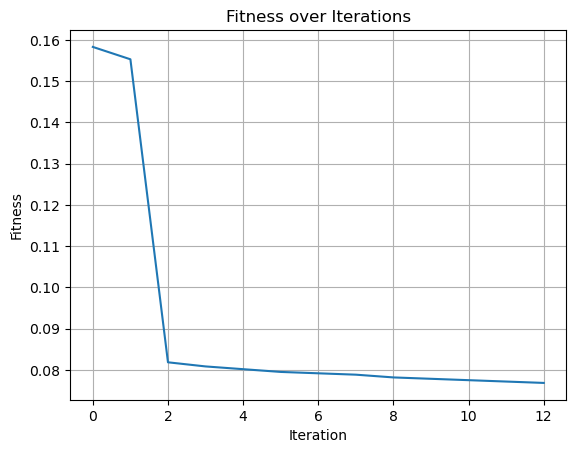

Best fitness: 0.07682051282051276
Finished processing BreastEW_50_samples dataset.

Running BSO on BreastEW_100_samples dataset...
(75, 30)


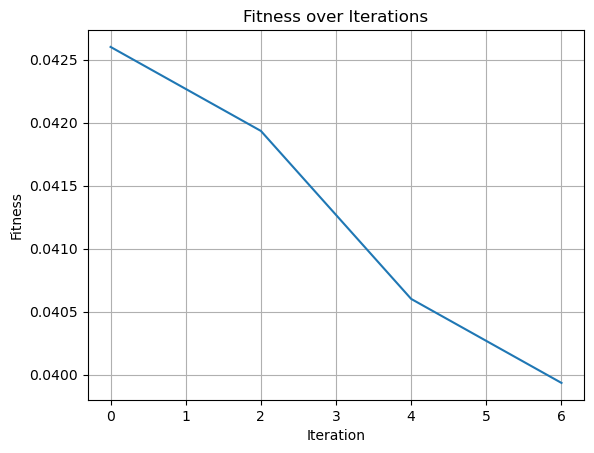

Best fitness: 0.03993333333333337
Finished processing BreastEW_100_samples dataset.

Running BSO on CongressEW_50_samples dataset...
(37, 16)


/var/folders/vt/h9vkwt452gb18m39l93j11hm0000gp/T/ipykernel_96149/46087999.py:236: RuntimeWarning: overflow encountered in exp
  M = np.exp(male_fitness[partner_idx] / female_fitness[i])
/var/folders/vt/h9vkwt452gb18m39l93j11hm0000gp/T/ipykernel_96149/46087999.py:236: RuntimeWarning: overflow encountered in exp
  M = np.exp(male_fitness[partner_idx] / female_fitness[i])


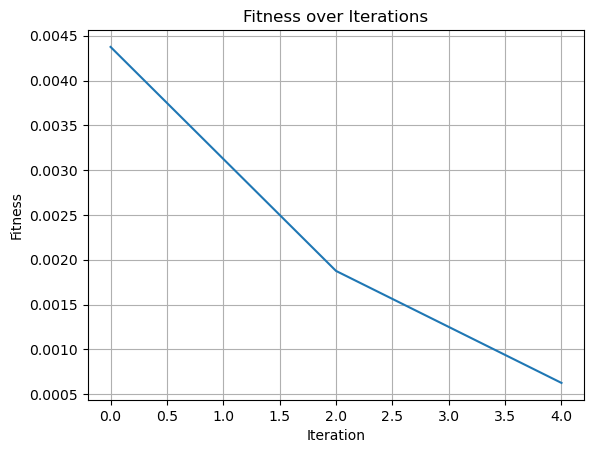

Best fitness: 0.0006250000000000006
Finished processing CongressEW_50_samples dataset.

Running BSO on CongressEW_100_samples dataset...
(75, 16)


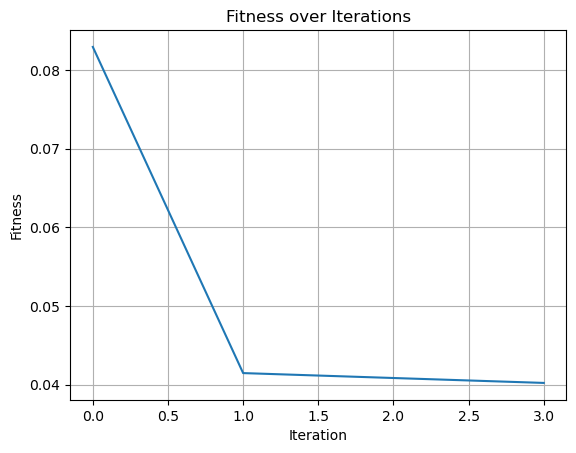

Best fitness: 0.04022500000000004
Finished processing CongressEW_100_samples dataset.

Running BSO on Sonar_50_samples dataset...
(37, 60)


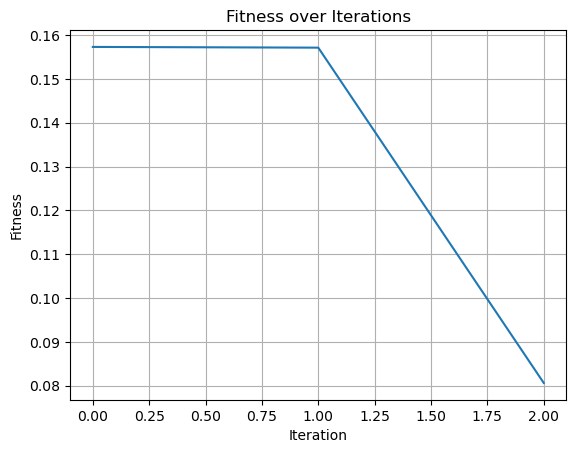

Best fitness: 0.0806538461538461
Finished processing Sonar_50_samples dataset.

Running BSO on Sonar_100_samples dataset...
(75, 60)


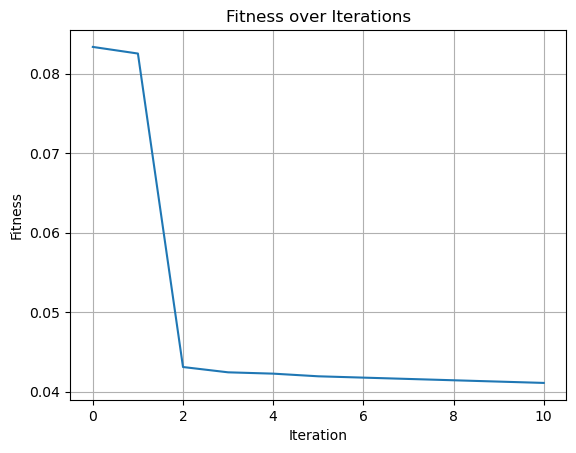

Best fitness: 0.04110000000000004
Finished processing Sonar_100_samples dataset.



In [13]:

datasets = [
    [
        './outputs/checkpoints/original_text_data_features/breastEW_50_samples_train_data.npy',
        './outputs/checkpoints/original_text_data_features/breastEW_50_samples_train_label.npy',
        './outputs/checkpoints/original_text_data_features/breastEW_50_samples_eval_data.npy',
        './outputs/checkpoints/original_text_data_features/breastEW_50_samples_eval_label.npy',
        ['0','1'],
        'BreastEW_50_samples'
    ],
    [
        './outputs/checkpoints/original_text_data_features/breastEW_100_samples_train_data.npy',
        './outputs/checkpoints/original_text_data_features/breastEW_100_samples_train_label.npy',
        './outputs/checkpoints/original_text_data_features/breastEW_100_samples_eval_data.npy',
        './outputs/checkpoints/original_text_data_features/breastEW_100_samples_eval_label.npy',
        ['0','1'],
        'BreastEW_100_samples'
    ],
    [
        './outputs/checkpoints/original_text_data_features/CongressEW_50_samples_train_data.npy',
        './outputs/checkpoints/original_text_data_features/CongressEW_50_samples_train_label.npy',
        './outputs/checkpoints/original_text_data_features/CongressEW_50_samples_eval_data.npy',
        './outputs/checkpoints/original_text_data_features/CongressEW_50_samples_eval_label.npy',
        ['0','1'],
        'CongressEW_50_samples'
    ],
    [
        './outputs/checkpoints/original_text_data_features/CongressEW_100_samples_train_data.npy',
        './outputs/checkpoints/original_text_data_features/CongressEW_100_samples_train_label.npy',
        './outputs/checkpoints/original_text_data_features/CongressEW_100_samples_eval_data.npy',
        './outputs/checkpoints/original_text_data_features/CongressEW_100_samples_eval_label.npy',
        ['0','1'],
        'CongressEW_100_samples'
    ],
    [
        './outputs/checkpoints/original_text_data_features/Sonar_50_samples_train_data.npy',
        './outputs/checkpoints/original_text_data_features/Sonar_50_samples_train_label.npy',
        './outputs/checkpoints/original_text_data_features/Sonar_50_samples_eval_data.npy',
        './outputs/checkpoints/original_text_data_features/Sonar_50_samples_eval_label.npy',
        ['0','1'],
        'Sonar_50_samples'
    ],
    [
        './outputs/checkpoints/original_text_data_features/Sonar_100_samples_train_data.npy',
        './outputs/checkpoints/original_text_data_features/Sonar_100_samples_train_label.npy',
        './outputs/checkpoints/original_text_data_features/Sonar_100_samples_eval_data.npy',
        './outputs/checkpoints/original_text_data_features/Sonar_100_samples_eval_label.npy',
        ['0','1'],
        'Sonar_100_samples'
    ]

]

for dataset in datasets:
    trainX_loc, trainy_loc, testX_loc, testy_loc, labels, dataset_name = dataset
    print(f"Running BSO on {dataset_name} dataset...")
    # Call the main BSO function
    mainBSO(trainX_loc, testX_loc, trainy_loc, testy_loc, MaxIter=50)
    print(f"Finished processing {dataset_name} dataset.\n")

In [18]:
def mainACO(trainX_loc, testX_loc, trainy_loc, testy_loc, MaxIter):

    # Load data
    trainX = np.load(trainX_loc)
    testX = np.load(testX_loc)
    trainy = np.load(trainy_loc)
    testy = np.load(testy_loc)

    # Get the shape of the training data
    n_samples, n_features = trainX.shape

    # Generate a binary population with values 0 or 1
    # Each individual has same number of bits as features
    agents = np.random.randint(0, 2, size=(n_samples, n_features))

    print(agents.shape)
    # generate initial binary population
    best_fitness = 1
    all_fitness = []
    best_agents = []
    for i in range(MaxIter):
        newgents,overall_fit,best_agent = ACO(agents, None, trainX, testX, trainy, testy, n_features, True, i, MaxIter)
        agents = newgents
        if overall_fit < best_fitness:
            best_fitness = overall_fit
        all_fitness.append(best_fitness)



    # convert all_fitness to numpy array
    all_fitness = np.array(all_fitness)
    # Plot the fitness over iterations
    plt.plot(all_fitness)
    plt.title('Fitness over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Fitness')
    plt.grid()
    plt.show()

    print("Best fitness:", np.min(all_fitness))

Running AC0 on BreastEW_50_samples dataset...
(37, 30)


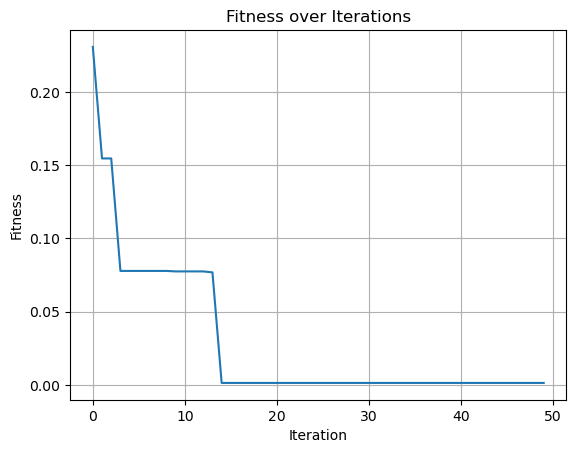

Best fitness: 0.0013333333333333346
Finished processing BreastEW_50_samples dataset.

Running AC0 on BreastEW_100_samples dataset...
(75, 30)


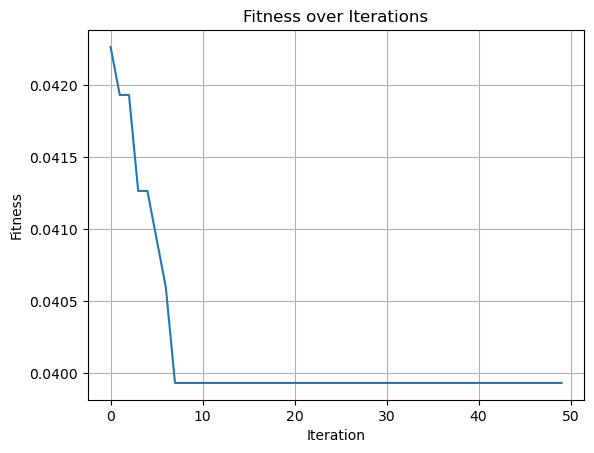

Best fitness: 0.03993333333333337
Finished processing BreastEW_100_samples dataset.

Running AC0 on CongressEW_50_samples dataset...
(37, 16)


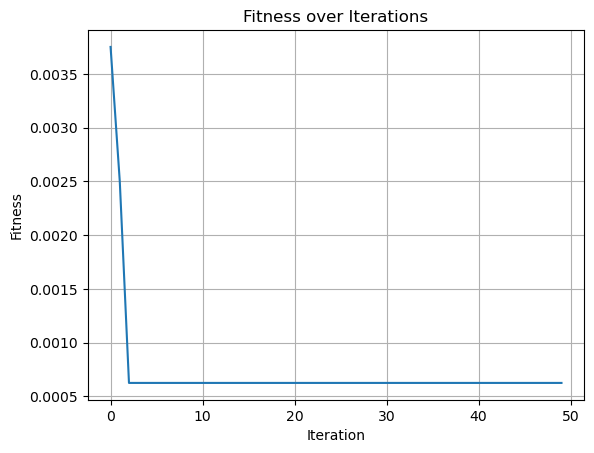

Best fitness: 0.0006250000000000006
Finished processing CongressEW_50_samples dataset.

Running AC0 on CongressEW_100_samples dataset...
(75, 16)


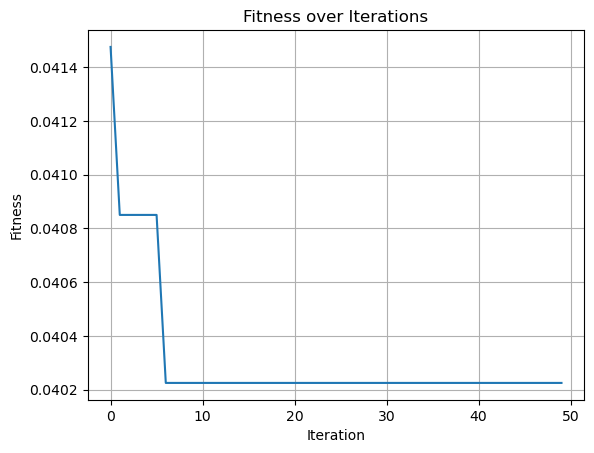

Best fitness: 0.04022500000000004
Finished processing CongressEW_100_samples dataset.

Running AC0 on Sonar_50_samples dataset...
(37, 60)


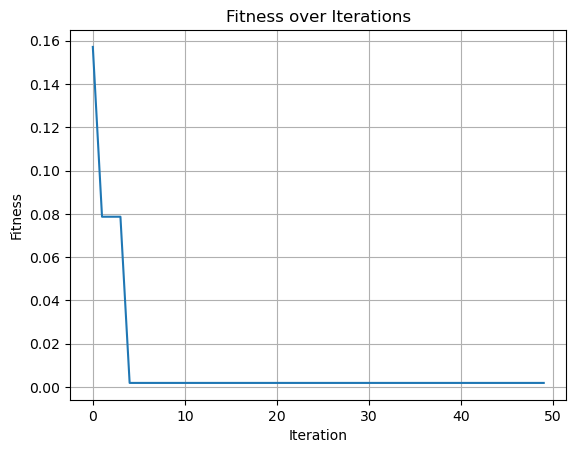

Best fitness: 0.0018333333333333348
Finished processing Sonar_50_samples dataset.

Running AC0 on Sonar_100_samples dataset...
(75, 60)


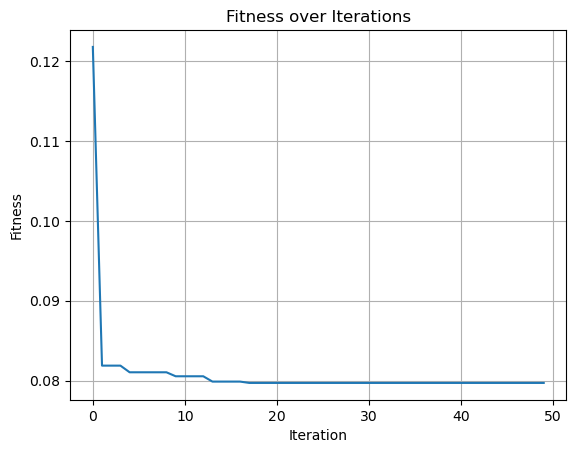

Best fitness: 0.07969999999999997
Finished processing Sonar_100_samples dataset.



In [19]:

datasets = [
    [
        './outputs/checkpoints/original_text_data_features/breastEW_50_samples_train_data.npy',
        './outputs/checkpoints/original_text_data_features/breastEW_50_samples_train_label.npy',
        './outputs/checkpoints/original_text_data_features/breastEW_50_samples_eval_data.npy',
        './outputs/checkpoints/original_text_data_features/breastEW_50_samples_eval_label.npy',
        ['0','1'],
        'BreastEW_50_samples'
    ],
    [
        './outputs/checkpoints/original_text_data_features/breastEW_100_samples_train_data.npy',
        './outputs/checkpoints/original_text_data_features/breastEW_100_samples_train_label.npy',
        './outputs/checkpoints/original_text_data_features/breastEW_100_samples_eval_data.npy',
        './outputs/checkpoints/original_text_data_features/breastEW_100_samples_eval_label.npy',
        ['0','1'],
        'BreastEW_100_samples'
    ],
    [
        './outputs/checkpoints/original_text_data_features/CongressEW_50_samples_train_data.npy',
        './outputs/checkpoints/original_text_data_features/CongressEW_50_samples_train_label.npy',
        './outputs/checkpoints/original_text_data_features/CongressEW_50_samples_eval_data.npy',
        './outputs/checkpoints/original_text_data_features/CongressEW_50_samples_eval_label.npy',
        ['0','1'],
        'CongressEW_50_samples'
    ],
    [
        './outputs/checkpoints/original_text_data_features/CongressEW_100_samples_train_data.npy',
        './outputs/checkpoints/original_text_data_features/CongressEW_100_samples_train_label.npy',
        './outputs/checkpoints/original_text_data_features/CongressEW_100_samples_eval_data.npy',
        './outputs/checkpoints/original_text_data_features/CongressEW_100_samples_eval_label.npy',
        ['0','1'],
        'CongressEW_100_samples'
    ],
    [
        './outputs/checkpoints/original_text_data_features/Sonar_50_samples_train_data.npy',
        './outputs/checkpoints/original_text_data_features/Sonar_50_samples_train_label.npy',
        './outputs/checkpoints/original_text_data_features/Sonar_50_samples_eval_data.npy',
        './outputs/checkpoints/original_text_data_features/Sonar_50_samples_eval_label.npy',
        ['0','1'],
        'Sonar_50_samples'
    ],
    [
        './outputs/checkpoints/original_text_data_features/Sonar_100_samples_train_data.npy',
        './outputs/checkpoints/original_text_data_features/Sonar_100_samples_train_label.npy',
        './outputs/checkpoints/original_text_data_features/Sonar_100_samples_eval_data.npy',
        './outputs/checkpoints/original_text_data_features/Sonar_100_samples_eval_label.npy',
        ['0','1'],
        'Sonar_100_samples'
    ]

]

for dataset in datasets:
    trainX_loc, trainy_loc, testX_loc, testy_loc, labels, dataset_name = dataset
    print(f"Running AC0 on {dataset_name} dataset...")
    # Call the main BSO function
    mainACO(trainX_loc, testX_loc, trainy_loc, testy_loc, MaxIter=50)
    print(f"Finished processing {dataset_name} dataset.\n")